In [ ]:
!pip install "dask[complete]"
!pip install pyarrow pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.6/242.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.6.4
    Uninstalling importlib-metadata-4.6.4:
      Successfully uninstalled importlib-metadata-4.6.4


In [ ]:
!pip install hdbscan


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 15.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import hdbscan
from sklearn.cluster import KMeans
from sklearn.metrics import recall_score, precision_score, accuracy_score, classification_report
import time
import pandas as pd
import dask.dataframe as dd
import glob
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial.distance import cdist
from warnings import filterwarnings
filterwarnings('ignore')


In [ ]:
# 1. Load Data from Parquet Files
data_dir = '/content/drive/MyDrive/Data_hasking'
file_list = sorted(glob.glob(f"{data_dir}/*.parquet"))[:40]
ddf = dd.read_parquet(file_list)

In [ ]:
# 2. Load Customer Data
tb_customers = dd.read_parquet('/content/drive/MyDrive/TB_CUSTOMERS.parquet')
tb_customers_df = tb_customers.compute()

In [ ]:
# Filter individual customers (CUSTOMER_TYPE == 'Cá nhân')
tb_customers_individual_df = tb_customers_df[tb_customers_df["CUSTOMER_TYPE"] == "Cá nhân"]
individual_customers = tb_customers_individual_df["CUST_CUSTNO"].unique().tolist()

In [ ]:
# 3. Filter Transactions for Individual Customers
ddf_filtered = ddf[['CUST_CUSTNO', 'AMOUNT', 'VALUEDATE']]
df_individual = ddf_filtered[ddf_filtered['CUST_CUSTNO'].isin(individual_customers)]
df_individual_df = df_individual.compute()

In [ ]:
# 4. Convert VALUEDATE to Datetime and Extract Date
df_individual_df['VALUEDATE'] = pd.to_datetime(df_individual_df['VALUEDATE'], errors='coerce')
df_individual_df['DATE_ONLY'] = df_individual_df['VALUEDATE'].dt.date

In [ ]:
# 5. Separate Deposits and Withdrawals
df_deposits = df_individual_df[df_individual_df['AMOUNT'] > 0]
df_withdrawals = df_individual_df[df_individual_df['AMOUNT'] < 0]

In [ ]:
# 6. Aggregate by Customer and Date
daily_deposits = df_deposits.groupby(['CUST_CUSTNO', 'DATE_ONLY'])['AMOUNT'].sum().reset_index(name='total_deposits')
daily_withdrawals = df_withdrawals.groupby(['CUST_CUSTNO', 'DATE_ONLY'])['AMOUNT'].sum().reset_index(name='total_withdrawals')

In [ ]:
# 7. Merge Deposits and Withdrawals Data
transactions = pd.merge(daily_deposits, daily_withdrawals, on=['CUST_CUSTNO', 'DATE_ONLY'], how='outer')
transactions['total_deposits'].fillna(0, inplace=True)
transactions['total_withdrawals'].fillna(0, inplace=True)

In [ ]:
# 8. Log Transform the Data
transactions['log_total_deposits'] = np.log1p(transactions['total_deposits'])
transactions['log_total_withdrawals'] = np.log1p(transactions['total_withdrawals'].abs())


In [ ]:
# 9. Prepare Data for Clustering
features = transactions[['log_total_deposits', 'log_total_withdrawals']].values

In [ ]:
# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

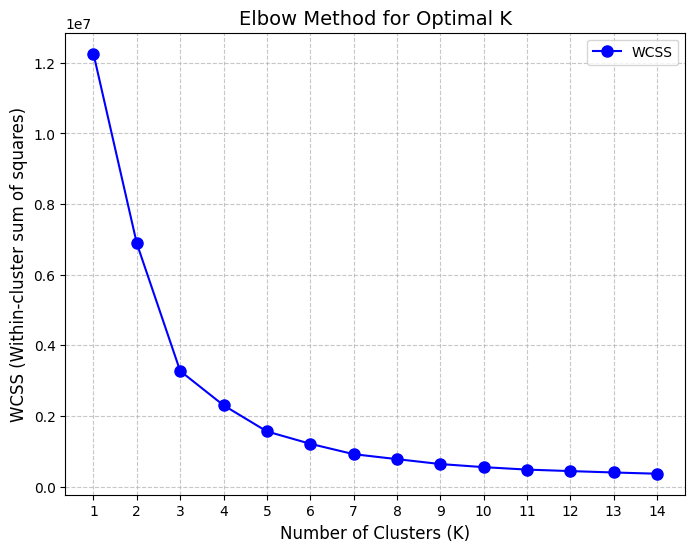

In [ ]:
# 10. Apply K-means clustering with different K values and compute WCSS (within-cluster sum of squares)
wcss = []
K_range = range(1, 15)  # We will try K from 1 to 15

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)  # inertia_ gives the WCSS for the clusters

# 11. Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(K_range, wcss, 'bo-', markersize=8, marker='o', color='b', label='WCSS')
plt.title('Elbow Method for Optimal K', fontsize=14)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('WCSS (Within-cluster sum of squares)', fontsize=12)
plt.xticks(K_range)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()


In [ ]:
# 10. Apply K-Means Clustering (We will use 3 clusters based on Elbow method)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_features)


In [ ]:
# Add the K-means labels to the transactions dataframe
transactions['kmeans_label'] = kmeans_labels

In [ ]:

cluster_counts = transactions.groupby('kmeans_label')['CUST_CUSTNO'].count()
cluster_counts


,CUST_CUSTNO
kmeans_label,
0,1731739
1,2180348
2,2216190


In [ ]:

# Rule-based anomalies
rule_15_anomalies = transactions[
    (transactions['total_deposits'] >= 6000000) &
    (transactions['total_withdrawals'].abs() >= 0.95 * transactions['total_deposits'])
]
rule_15_anomalies

,CUST_CUSTNO,DATE_ONLY,total_deposits,total_withdrawals,log_total_deposits,log_total_withdrawals,kmeans_label
612,000975b0ee367856502b174994023821120d5730b3fcd3...,2023-08-22,10469355.99,-10051700.46,16.163963,16.123252,2
618,000975b0ee367856502b174994023821120d5730b3fcd3...,2023-08-29,7179280.10,-7513252.10,15.786710,15.832179,2
3876,003e0235aab29e1788ce064113f24f8703921030065318...,2023-08-07,11236003.08,-12497903.80,16.234634,16.341072,2
5343,00527a90ea8ac7e0cb02edb41f08ec69cacd447c1e06a3...,2023-08-03,7162326.10,-7162163.01,15.784346,15.784323,2
5345,00527a90ea8ac7e0cb02edb41f08ec69cacd447c1e06a3...,2023-08-07,6172231.88,-6342641.09,15.635571,15.662806,2
...,...,...,...,...,...,...,...
4091570,ffa1f3b742233373eedaf14f21c5c2833beed4b44eb6f3...,2023-08-29,27950000.05,-40949450.00,17.145928,17.527849,2
4092093,ffabda738508e4c6a75e696549413207707ac1366d57a8...,2023-08-11,6474800.00,-6316800.00,15.683428,15.658723,2
4095791,ffecb0aaab47e4d92ac4176cdee0c3d9dd4617216035c8...,2023-08-31,6242683.78,-6231263.79,15.646921,15.645090,2
4096302,fff5865d6fd5d7a5893f904b1cb18479fa79ea3b09c4b3...,2023-08-07,9435971.82,-9437298.90,16.060040,16.060180,2


In [ ]:

# Group transactions by cluster and calculate summary statistics
cluster_summary = transactions.groupby('kmeans_label').agg({
    'total_deposits': ['mean', 'std', 'min', 'max'],
    'total_withdrawals': ['mean', 'std', 'min', 'max']
})

# Count the number of anomalies in each cluster
anomaly_counts = transactions[transactions.index.isin(rule_15_anomalies.index)].groupby('kmeans_label').size()

# Display the summary statistics and anomaly counts for each cluster
print("Summary Statistics and Anomaly Counts by Cluster:")
for cluster_label in transactions['kmeans_label'].unique():
    print(f"\nCluster {cluster_label}:")
    print(cluster_summary.loc[cluster_label])
    if cluster_label in anomaly_counts.index:
        print(f"Number of Anomalies: {anomaly_counts[cluster_label]}")
    else:
        print("Number of Anomalies: 0")


Summary Statistics and Anomaly Counts by Cluster:

Cluster 2:
total_deposits     mean    1.582287e+05
                   std     2.602001e+06
                   min     7.130000e+00
                   max     9.549927e+08
total_withdrawals  mean   -1.584363e+05
                   std     2.682029e+06
                   min    -8.917823e+08
                   max    -1.000000e+01
Name: 2, dtype: float64
Number of Anomalies: 5086

Cluster 0:
total_deposits     mean    1.009375e+04
                   std     2.887631e+05
                   min     0.000000e+00
                   max     2.400000e+08
total_withdrawals  mean   -1.077574e+01
                   std     2.881030e+01
                   min    -1.890000e+02
                   max     0.000000e+00
Name: 0, dtype: float64
Number of Anomalies: 0

Cluster 1:
total_deposits     mean    3.039846e+00
                   std     1.595676e+01
                   min     0.000000e+00
                   max     1.800000e+02
total_withdrawals

In [ ]:
# Define the range of values you want to experiment with
min_cluster_sizes = [5, 10, 20, 25, 30]
min_samples_values = [100, 200, 300, 400, 500]

# Create a copy of the dataframe to store results for different combinations
results = transactions.copy()

# Loop over the different values for min_cluster_size and min_samples
for min_cluster_size in min_cluster_sizes:
    for min_samples in min_samples_values:
        # Select the data for the cluster containing anomalies (cluster 2)
        cluster_2_data = scaled_features[transactions['kmeans_label'] == 2]

        # Apply HDBSCAN with different values of min_cluster_size and min_samples
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
        hdbscan_labels = clusterer.fit_predict(cluster_2_data)

        # Add the HDBSCAN labels to the transactions dataframe for cluster 2
        label_column = f'hdbscan_label_{min_cluster_size}_{min_samples}'
        results.loc[results['kmeans_label'] == 2, label_column] = hdbscan_labels

In [ ]:
for min_cluster_size in min_cluster_sizes:
    for min_samples in min_samples_values:
        label_column = f'hdbscan_label_{min_cluster_size}_{min_samples}'

        # Get the predicted anomalies from the HDBSCAN labels (e.g., label -1 might be noise/anomaly)
        predicted_anomalies = results[results[label_column] == -1].index

        # Get the true anomalies from rule_15_anomalies
        true_anomalies = rule_15_anomalies.index

        # Calculate the recall score
        recall = recall_score(results.index.isin(true_anomalies), results.index.isin(predicted_anomalies), average='binary')

        print(f"Recall for min_cluster_size={min_cluster_size}, min_samples={min_samples}: {recall}")


Recall for min_cluster_size=5, min_samples=100: 0.6222965001966182
Recall for min_cluster_size=5, min_samples=200: 0.7066456940621313
Recall for min_cluster_size=5, min_samples=300: 0.6989775855289029
Recall for min_cluster_size=5, min_samples=400: 0.7791977978765238
Recall for min_cluster_size=5, min_samples=500: 0.8079040503342508
Recall for min_cluster_size=10, min_samples=100: 0.6224931183641369
Recall for min_cluster_size=10, min_samples=200: 0.7058592213920566
Recall for min_cluster_size=10, min_samples=300: 0.7066456940621313
Recall for min_cluster_size=10, min_samples=400: 0.78273692489186
Recall for min_cluster_size=10, min_samples=500: 0.8149823043649234
Recall for min_cluster_size=20, min_samples=100: 0.6224931183641369
Recall for min_cluster_size=20, min_samples=200: 0.7058592213920566
Recall for min_cluster_size=20, min_samples=300: 0.7066456940621313
Recall for min_cluster_size=20, min_samples=400: 0.7858828155721589
Recall for min_cluster_size=20, min_samples=500: 0.8149

In [ ]:
min_cluster_size = 30
min_samples = 500
label_column = f'hdbscan_label_{min_cluster_size}_{min_samples}'

# Get the predicted anomalies from the HDBSCAN labels (e.g., label -1 might be noise/anomaly)
predicted_anomalies = results[results[label_column] == -1].index

# Get the true anomalies from rule_15_anomalies
true_anomalies = rule_15_anomalies.index

# Calculate the accuracy score
accuracy = accuracy_score(results.index.isin(true_anomalies), results.index.isin(predicted_anomalies))

print(f"Accuracy for min_cluster_size={min_cluster_size}, min_samples={min_samples}: {accuracy}")


Accuracy for min_cluster_size=30, min_samples=500: 0.7624404053537397
